In [77]:
# Updating these names should be enough to run this notebook

data_folder = r"QueensToChildrends"
notebook_save_folder = r"SavedNotebooks"

groundtruth_file = r"segmentation-test.npy"
prediction_file=r"prediction-test.npy"

acceptable_margin_mm = 1
mm_per_pixel = 1

In [78]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os 
import scipy.ndimage

from random import sample

from local_vars import root_folder

In [79]:
# Read data arrays

data_fullpath = os.path.join(root_folder, data_folder)

groundtruth_fullname = os.path.join(data_fullpath, groundtruth_file)
prediction_fullname = os.path.join(data_fullpath, prediction_file)

print("Reading ground truth from:  {}".format(groundtruth_fullname))
print("Reading predictions from:   {}".format(prediction_fullname))

groundtruth_data = np.load(groundtruth_fullname)
prediction_data = np.load(prediction_fullname)

num_groundtruth = groundtruth_data.shape[0]
num_prediction = prediction_data.shape[0]

print("\nFound {} ground truth images and {} predictions".format(num_groundtruth, num_prediction))

if num_groundtruth != num_prediction:
    print("Number of images should be equal!")
    raise

Reading ground truth from:  c:\Data\QueensToChildrends\segmentation-test.npy
Reading predictions from:   c:\Data\QueensToChildrends\prediction-test.npy

Found 477 ground truth images and 477 predictions


In [80]:
# Dilate only along image axes, not across images

def dilate_stack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

In [81]:
# Dilate ground truth

acceptable_margin_pixel = int(acceptable_margin_mm / mm_per_pixel)

acceptable_region = dilate_stack(groundtruth_data[:, :, :, 0], acceptable_margin_pixel)

In [82]:
# Computing regions for evaluation metrics

true_pos_prediction = np.minimum(groundtruth_data[:,:,:,0], prediction_data[:,:,:,1])
not_acceptable_region = 1 - acceptable_region
false_pos_prediction = np.minimum(not_acceptable_region, prediction_data[:, :, :, 1])

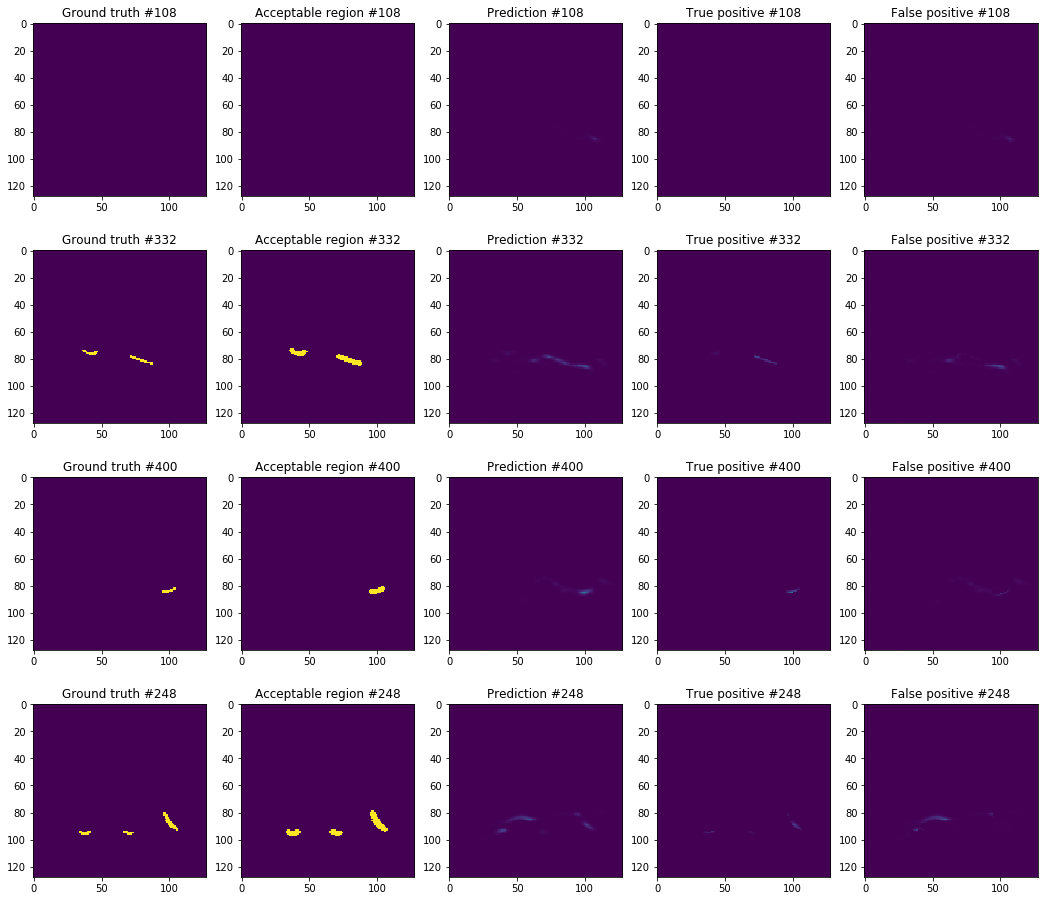

In [85]:
# Show a sample of images to check for errors

num_show = 4
num_columns = 5

all_indices = [i for i in range(num_groundtruth)]
sample_indices = sample(all_indices, num_show)

fig = plt.figure(figsize=(18, num_show * 4))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_columns, i * num_columns + 1)
    img0 = a0.imshow(groundtruth_data[sample_indices[i],:,:,0])
    a0.set_title("Ground truth #{}".format(sample_indices[i]))
    
    a1 = fig.add_subplot(num_show, num_columns, i * num_columns + 2)
    img1 = a1.imshow(acceptable_region[sample_indices[i],:,:])
    a1.set_title("Acceptable region #{}".format(sample_indices[i]))
    
    a2 = fig.add_subplot(num_show, num_columns, i * num_columns + 3)
    img2 = a2.imshow(prediction_data[sample_indices[i],:,:,1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    # c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    
    a3 = fig.add_subplot(num_show, num_columns, i * num_columns + 4)
    img3 = a3.imshow(true_pos_prediction[sample_indices[i],:,:], vmin=0.0, vmax=1.0)
    a3.set_title("True positive #{}".format(sample_indices[i]))
    # c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    
    a4 = fig.add_subplot(num_show, num_columns, i * num_columns + 5)
    img4 = a4.imshow(false_pos_prediction[sample_indices[i],:,:], vmin=0.0, vmax=1.0)
    a4.set_title("False positive #{}".format(sample_indices[i]))
    # c = fig.colorbar(img4, fraction=0.046, pad=0.04)
    

In [84]:
fpp = np.sum(false_pos_prediction[:,:,:])
tna = np.sum(not_acceptable_region[:,:,:])
tpp = np.sum(true_pos_prediction)
tpa = np.sum(groundtruth_data[:,:,:,0])

print("Total false positive prediction amount per image: {:.2f}".format(fpp / num_groundtruth))
print("Total true negative area per image:               {:.2f}".format(tna / num_groundtruth))
print("  {:.2f}% of the true negative area was correctly predicted".format((tna - fpp) / tna * 100))
print("")
print("Total true positive prediction amount per image: {:.2f}".format(tpp / num_groundtruth))
print("Total true position area per image:              {:.2f}".format(tpa / num_groundtruth))
print("  {:.2f}% of the true positive area was correctly predicted".format(tpp / tpa * 100))


Total false positive prediction amount per image: 13.94
Total true negative area per image:               16282.33
  99.91% of the true negative area was correctly predicted

Total true positive prediction amount per image: 5.97
Total true position area per image:              47.14
  12.66% of the true positive area was correctly predicted
